In [1]:
                             # CNN
import numpy as np
from numpy.random import seed

import pandas as pd
import os
import matplotlib.pyplot as plt
from matplotlib import image
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
import glob
import seaborn as sns

# Tensorflow Packages
import tensorflow as tf
from tensorflow import keras
from tensorflow.random import set_seed
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, GlobalAveragePooling2D, MaxPooling2D, Conv2D
from keras.applications.mobilenet_v2 import MobileNetV2 
from keras.applications.mobilenet_v2 import preprocess_input

print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)

import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


TensorFlow version: 2.11.0
Keras version: 2.11.0


In [2]:
seed_val = 42 # Seed for reproducible results
seed(seed_val) # numpy's seed
set_seed(seed_val) # tensorflow's seed

AUTOTUNE = tf.data.experimental.AUTOTUNE
batch_size=128
IMG_WIDTH, IMG_HEIGHT = 32, 32
EPOCHS = 20

In [3]:
from zipfile import ZipFile

train_path = "/kaggle/input/aerial-cactus-identification/train.zip"

with ZipFile(train_path, 'r') as f:
    f.extractall()

In [4]:
df = pd.read_csv("/kaggle/input/aerial-cactus-identification/train.csv")
df.head()

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


In [5]:
print(f'The dataset has {df.shape[0]} images.')

The dataset has 17500 images.


In [6]:
df.has_cactus.value_counts(normalize=True)

1    0.750629
0    0.249371
Name: has_cactus, dtype: float64

In [7]:
df['img_format'] = df.id.str.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))
df.img_format.value_counts()

True    17500
Name: img_format, dtype: int64

In [8]:
%%capture
!pip install imagededup

In [9]:
from imagededup.methods import PHash
from imagededup.utils import plot_duplicates


image_dir = '/kaggle/working/train'
phasher = PHash()

encodings = phasher.encode_images(image_dir=image_dir)

Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:00<00:00, 107MB/s]
2023-05-24 17:08:40,019: INFO Start: Calculating hashes...
100%|██████████| 17500/17500 [00:07<00:00, 2254.62it/s]
2023-05-24 17:08:48,198: INFO End: Calculating hashes!


In [10]:
duplicates = phasher.find_duplicates(encoding_map=encodings)
duplicates_dict  ={k: v for k, v in sorted(duplicates.items(), key=lambda x: len(x[1]), reverse=True) if len(v)!=0}

/opt/conda/lib/python3.10/site-packages/imagededup/methods/hashing.py:317: RuntimeWarning: Parameter num_enc_workers has no effect since encodings are already provided
  warnings.warn('Parameter num_enc_workers has no effect since encodings are already provided', RuntimeWarning)
2023-05-24 17:08:48,248: INFO Start: Evaluating hamming distances for getting duplicates
2023-05-24 17:08:48,250: INFO Start: Retrieving duplicates using Cython Brute force algorithm
100%|██████████| 17500/17500 [03:27<00:00, 84.28it/s]
2023-05-24 17:12:15,995: INFO End: Retrieving duplicates using Cython Brute force algorithm
2023-05-24 17:12:15,996: INFO End: Evaluating hamming distances for getting duplicates


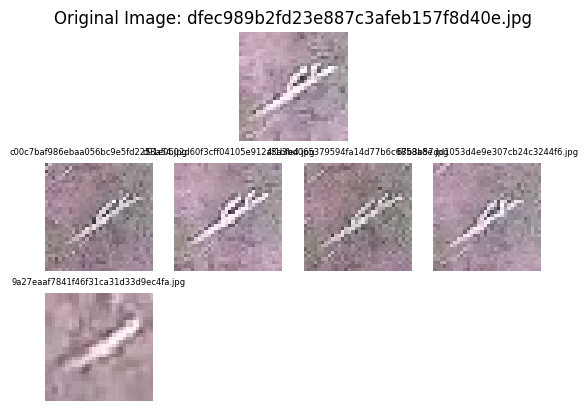

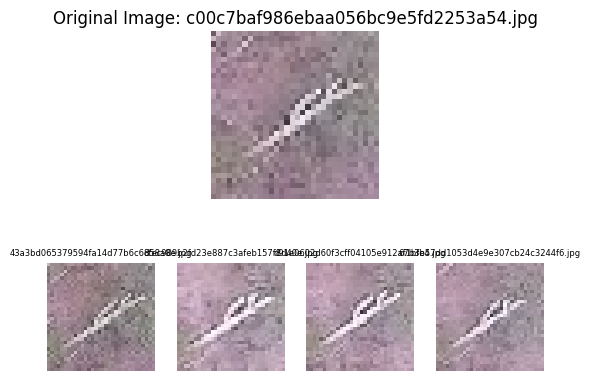

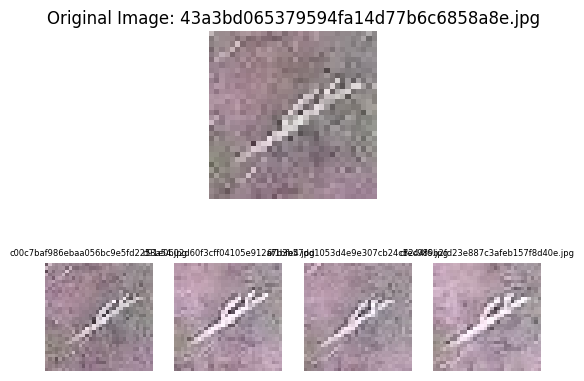

In [11]:
# Ploting Duplicates Images.
for i in range(3):
    plot_duplicates(image_dir=image_dir, duplicate_map=duplicates_dict, filename=list(duplicates_dict.keys())[i])

In [12]:
duplicate_list = [v for (k,v) in duplicates_dict.items()]
duplicates = []
for i in duplicate_list:
    for p in i:
        duplicates.append(p)
        
print(f'There are {len(duplicates)} duplicated images in the directory. That is: {np.round((len(duplicates)/len(df))*100, 2)}% of the total images')

There are 1084 duplicated images in the directory. That is: 6.19% of the total images


In [13]:
df['id'] = df.id.apply(lambda x: os.path.join("/kaggle/working/train", x))

In [14]:
duplicates_path = []
for dup in duplicates:
    path = os.path.join("/kaggle/working/train", dup)
    duplicates_path.append(path)

In [15]:
idx_duplicates = df.id.isin(duplicates_path)
df = df[~idx_duplicates]

In [16]:
df.isna().sum()

id            0
has_cactus    0
img_format    0
dtype: int64

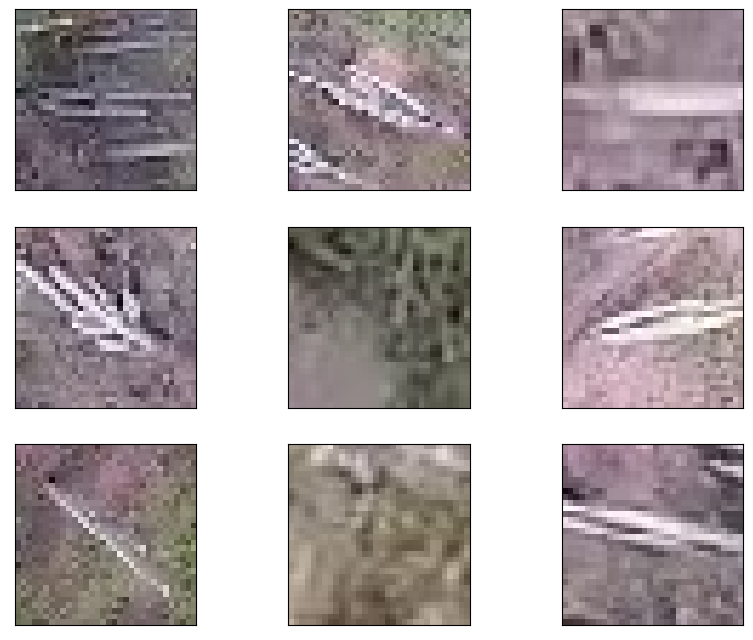

In [17]:
img_paths = os.listdir(image_dir)

fig = plt.figure(figsize=(10, 8))
for idx, img in enumerate(np.random.choice(img_paths, 9)):
    ax = fig.add_subplot(3,3, idx+1, xticks=[], yticks=[])
    im = image.imread(os.path.join(image_dir, img))
    plt.imshow(im)

In [18]:
df.has_cactus.value_counts()

1    12281
0     4353
Name: has_cactus, dtype: int64

In [19]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
total = len(df)
weight_for_0 = (1/ 4353.0) * (total/ 2.0)
weight_for_1 = (1/ 12281.0) * (total/ 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.91
Weight for class 1: 0.68


In [20]:
def process_path(file_path, label, img_size=[IMG_WIDTH, IMG_HEIGHT]):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, size=img_size)
    return img, label

def configure_for_performance(ds):
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

In [21]:
images_path = df.id.values
labels = df.has_cactus.values

In [22]:
images_ds = tf.data.Dataset.from_tensor_slices((images_path))
labels_ds = tf.data.Dataset.from_tensor_slices((labels))

train_ds = tf.data.Dataset.zip((images_ds, labels_ds))

In [23]:
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [24]:
train_ds = configure_for_performance(train_ds)

In [25]:
val_size = int(tf.data.experimental.cardinality(train_ds).numpy() * 0.2)
train_ds = train_ds.skip(val_size)
val_ds = train_ds.take(val_size)

In [26]:
# initial_bias = np.log(pos/neg)
initial_bias = np.log([12281.0/4353.0]) # Set inital bias for faster convergence 

output_bias = tf.keras.initializers.Constant(initial_bias)

In [27]:
model = tf.keras.Sequential([
        Conv2D(16, 3, padding='same', activation='relu', input_shape=(32, 32, 3)),
        MaxPooling2D(),
        Conv2D(32, 3, padding='same', activation='relu'),
        MaxPooling2D(),
        Dropout(rate=.3, seed=seed_val),
        Conv2D(64, 3, padding='same', activation='relu'),
        MaxPooling2D(),
        Dropout(rate=.3, seed=seed_val),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid', bias_initializer=output_bias)
    ])
    
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=['accuracy'])

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 32)         0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 8, 8, 32)          0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 64)          1

In [29]:
history = model.fit(x=train_ds, 
                    batch_size=batch_size, 
                    validation_data=val_ds,
                    epochs=EPOCHS, 
                    class_weight=class_weight)

Epoch 1/20


2023-05-24 17:12:26.117592: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


104/104 [==============================] - 11s 32ms/step - loss: 1.5936 - accuracy: 0.7419 - val_loss: 0.2991 - val_accuracy: 0.8786
Epoch 2/20
104/104 [==============================] - 3s 22ms/step - loss: 0.2654 - accuracy: 0.8964 - val_loss: 0.2285 - val_accuracy: 0.9222
Epoch 3/20
104/104 [==============================] - 3s 21ms/step - loss: 0.2014 - accuracy: 0.9254 - val_loss: 0.1347 - val_accuracy: 0.9537
Epoch 4/20
104/104 [==============================] - 3s 22ms/step - loss: 0.1809 - accuracy: 0.9330 - val_loss: 0.1356 - val_accuracy: 0.9561
Epoch 5/20
104/104 [==============================] - 3s 22ms/step - loss: 0.1414 - accuracy: 0.9466 - val_loss: 0.0914 - val_accuracy: 0.9675
Epoch 6/20
104/104 [==============================] - 2s 22ms/step - loss: 0.1208 - accuracy: 0.9538 - val_loss: 0.0744 - val_accuracy: 0.9763
Epoch 7/20
104/104 [==============================] - 3s 24ms/step - loss: 0.1043 - accuracy: 0.9608 - val_loss: 0.0654 - val_accuracy: 0.9775
Epoch 8/2

In [30]:
def plot_training(hist):
    '''
    This function take training model and plot history of accuracy and losses with the best epoch in both of them.
    '''

    # Define needed variables
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    # Plot training history
    plt.figure(figsize= (17, 5))

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    sns.despine()

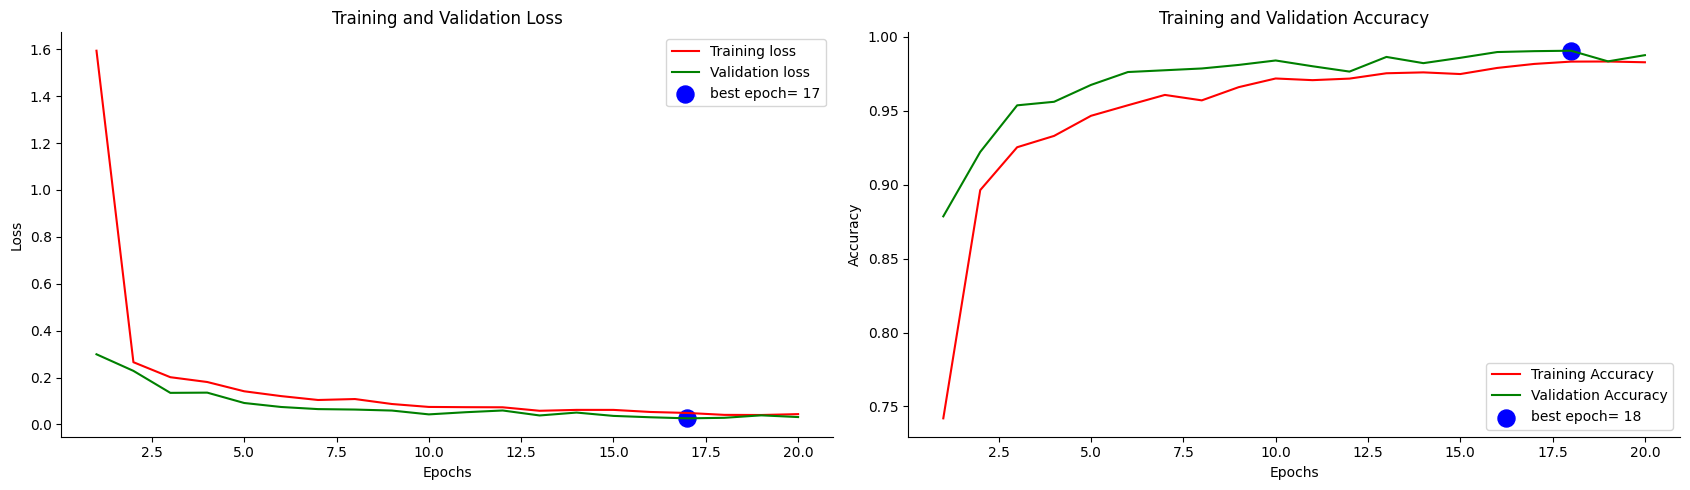

In [31]:
plot_training(history)